# We will create a model using a form with 3 input

In [83]:
pip install xgboost

In [84]:
pip install newspaper3k

Note: you may need to restart the kernel to use updated packages.


In [85]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.decomposition import PCA
import seaborn as sns
import requests
import seaborn as sns
from newspaper import Article
import requests
from bs4 import BeautifulSoup

In [2]:
from xgboost import plot_importance, XGBClassifier

## Data cleaning 

In [3]:
def cleancols(cols):
    x = [y.lower().strip() for y in cols]
    return x

data = pd.read_csv("OnlineNewsPopularity.csv")
data.columns = cleancols(data.columns)
y_labels = data['shares'] #the feature to be predicted
df = data.drop(columns = ['url','timedelta','shares'],axis = 1) #url and timedelta are of no use to us


In [4]:
pca = PCA(n_components = 12)
df_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
df_red = pca.fit_transform(df_scaled) #applying PCA on the standardized data
explainedfeats = pd.DataFrame(pca.components_,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10','PC-11','PC-12'],columns = df.columns)


In [5]:
explainedfeats

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
PC-1,0.041979,-0.149649,-0.006699,-0.010055,-0.009564,-0.166025,-0.135398,-0.089174,-0.058961,-0.293563,...,-0.347273,-0.076551,-0.352052,0.189984,0.166587,0.105072,-0.069004,-0.078815,0.039471,-0.082117
PC-2,0.069595,0.076440,-0.000311,0.000734,-0.000777,0.106679,0.006826,0.106503,0.134781,0.027278,...,0.042466,0.036631,0.028537,-0.262792,-0.286400,-0.043076,0.080580,-0.069466,-0.021195,0.063091
PC-3,0.013316,-0.141507,-0.009776,-0.013945,-0.012858,-0.033681,-0.029931,0.013748,0.031980,-0.188442,...,-0.048869,-0.006298,-0.073719,0.145555,0.215238,-0.009037,0.092856,0.117630,-0.074984,0.102080
PC-4,-0.002079,-0.005674,0.576608,0.576341,0.576468,-0.006959,0.002289,0.012871,-0.003799,0.011458,...,-0.006801,0.004842,-0.012630,0.007702,0.013948,-0.003437,-0.008897,-0.004140,-0.002935,-0.008999
PC-5,-0.051179,0.043771,0.015008,0.016640,0.014408,0.060412,0.069161,0.078894,-0.047763,-0.039675,...,-0.047300,-0.005763,-0.038141,0.043487,0.001533,0.064222,-0.034102,-0.024580,0.043435,-0.033419
PC-6,-0.082133,-0.015416,-0.010555,-0.009963,-0.008100,-0.019983,-0.014086,-0.120465,-0.071660,0.175138,...,0.037766,0.036680,0.011494,-0.034475,-0.020403,-0.059826,-0.299692,-0.186602,0.248283,-0.300551
PC-7,-0.055442,-0.247958,0.001670,-0.005074,0.002251,-0.215295,-0.225181,-0.202927,0.012005,0.061956,...,0.061209,0.152466,-0.055865,-0.116893,0.013578,-0.173232,-0.026269,-0.061851,0.034710,-0.033813
PC-8,-0.023011,0.230089,0.000456,0.006498,0.001752,0.178052,0.082804,0.061425,-0.031661,0.049128,...,-0.022543,-0.172510,0.102810,0.052810,-0.071293,0.132200,-0.115414,-0.031887,0.091502,-0.101029
PC-9,0.021477,0.069973,0.005985,0.007898,0.007085,0.017424,-0.060616,-0.080738,-0.032934,0.016688,...,-0.083860,-0.158265,-0.005450,0.022040,-0.042689,0.061706,0.316931,0.219828,-0.289502,0.329299
PC-10,0.093339,-0.124132,0.002608,0.000285,0.003304,-0.091325,-0.131919,-0.100675,-0.049554,0.121492,...,0.118395,0.180230,0.018121,-0.001332,0.059831,-0.087773,0.239749,0.153433,-0.187309,0.239603


C:\Users\Utilisateur\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


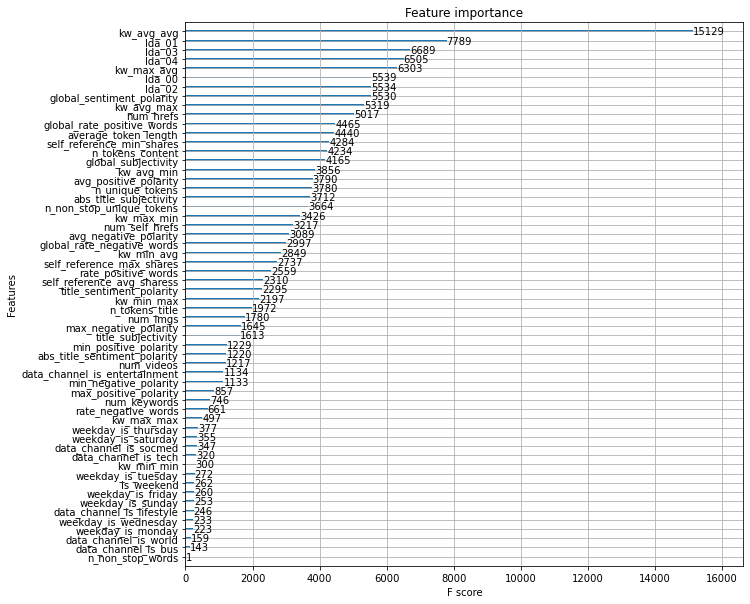

In [7]:
xgb = XGBClassifier(max_depth = 10,random_state = 0)
xgb.fit(df,y_labels)
fig, ax = plt.subplots(1,1,figsize=(10,10))
impplot = plot_importance(xgb,ax = ax)
plt.show()

In [8]:
impfeats = [impplot.get_yticklabels()[::-1][i].get_text() for i in range(0,20)]
print(impfeats)
impfeats = ['n_tokens_title', 'n_tokens_content', 'kw_max_avg', 'kw_avg_avg', 'n_unique_tokens', 'average_token_length', 'num_hrefs', 'n_non_stop_unique_tokens', 'kw_avg_max', 'self_reference_min_shares', 'lda_03', 'lda_02', 'global_subjectivity', 'lda_00', 'kw_avg_min', 'lda_04', 'lda_01', 'kw_max_min', 'avg_positive_polarity', 'global_sentiment_polarity']
#after several tries we decided those were the main features to keep.

['kw_avg_avg', 'lda_01', 'lda_03', 'lda_04', 'kw_max_avg', 'lda_00', 'lda_02', 'global_sentiment_polarity', 'kw_avg_max', 'num_hrefs', 'global_rate_positive_words', 'average_token_length', 'self_reference_min_shares', 'n_tokens_content', 'global_subjectivity', 'kw_avg_min', 'avg_positive_polarity', 'n_unique_tokens', 'abs_title_subjectivity', 'n_non_stop_unique_tokens']


# Creation of the text processing functions

In [9]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))
from textblob import TextBlob #for subjectivity and polarity 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def tokenizetext(text):
    return word_tokenize(text)
def words(text):
    l = [word for word in word_tokenize(text) if word.isalpha()]
    return l
def unique_words(text):
    return list(set(words(text)))
def rate_uni_words(text):
    uni_words = len(unique_words(text))/len(words(text))
    return uni_words
def avglengthtoken(text):
    w = words(text)
    sum = 0
    for item in w:
        sum+=len(item)
    avglen = sum/len(w)
    return avglen
def n_non_stop_unique_tokens(text):
    uw = unique_words(text)
    n_uw = [item for item in uw if item not in stopwords]
    w = words(text)
    n_w = [item for item in w if item not in stopwords]
    rate_nsut = len(n_uw)/len(n_w)
    return rate_nsut
def numlinks(article):
    return len(BeautifulSoup(article).findAll('link'))
def get_subjectivity(a_text):
    return a_text.sentiment.subjectivity
def get_polarity(a_text):
    return a_text.sentiment.polarity
def word_polarity(words):
    pos_words = []
    ppos_words = [] # polarity of pos words
    neg_words = []
    pneg_words = [] # polarity of negative words
    neu_words = []
    pneu_words = [] # polarity of neutral words
    for w in words:
        an_word = TextBlob(w)
        val = an_word.sentiment.polarity
        if val > 0:
            pos_words.append(w)
            ppos_words.append(val)
        if val < 0:
            neg_words.append(w)
            pneg_words.append(val)
        if val == 0 :
            neu_words.append(w)
            pneu_words.append(val)
    return pos_words,ppos_words,neg_words,pneg_words,neu_words,pneu_words
def avg_pol_pw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[1])/len(res[0])
def avg_pol_nw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[3])/len(res[2])

In [13]:
import nltk
nltk.download('punkt')
def masterDF(titre, texte, categ): #0 world / 1 tech / 2 social / 3 business / 4 entertainement / 5 lifestyle
    finrows = []
    row = {}
    row['n_tokens_title'] = len(words(titre))
    row['n_tokens_content'] = len(words(texte))
    row['n_unique_tokens'] = len(unique_words(texte))
    row['average_token_length'] = avglengthtoken(texte)
    row['n_non_stop_unique_tokens'] = n_non_stop_unique_tokens(texte)
    row['num_hrefs'] = numlinks(texte)
    
    analysed_text = TextBlob(texte)
    row['global_subjectivity'] = get_subjectivity(analysed_text)
    row['avg_positive_polarity'] = avg_pol_pw(texte)
    row['global_sentiment_polarity'] = get_polarity(analysed_text)
    finrows.append(row)
    
    liste = ["data_channel_is_world", "data_channel_is_tech", "data_channel_is_socmed", "data_channel_is_bus", "data_channel_is_entertainment", "data_channel_is_lifestyle"]
    row["data_channel_is_world"] =0
    row["data_channel_is_tech"]=0
    row["data_channel_is_socmed"]=0
    row["data_channel_is_bus"]=0
    row["data_channel_is_entertainment"]=0
    row["data_channel_is_lifestyle"]=0
    row[liste[categ]] = 1
    
    return finrows
    
#converting the list to a dataframe

finrows = masterDF("titre","texte", 0)

masterdf = pd.DataFrame(finrows, columns = ['n_tokens_title','n_tokens_content','n_unique_tokens','average_token_length','n_non_stop_unique_tokens','num_hrefs','global_subjectivity',
                                   'avg_positive_polarity','global_sentiment_polarity', 'data_channel_is_world',"data_channel_is_tech", "data_channel_is_socmed","data_channel_is_bus","data_channel_is_entertainment","data_channel_is_lifestyle"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-10-dbd0a45b2111>:54: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(res[1])/len(res[0])


# Model creation with the choosen parametres

- Those parameters are : 
'n_tokens_title','n_tokens_content','n_unique_tokens','average_token_length','n_non_stop_unique_tokens','num_hrefs','global_subjectivity', 'avg_positive_polarity','global_sentiment_polarity', 'data_channel_is_world',"data_channel_is_tech", "data_channel_is_socmed","data_channel_is_bus","data_channel_is_entertainment","data_channel_is_lifestyle"

They can be used on any article we want with asked : The tittle, the text and the categorie

In [22]:
df_reduced = df[masterdf.columns] #We take the df data but only the columns that we want (the ones just on top)
df_reduced

,n_tokens_title,n_tokens_content,n_unique_tokens,average_token_length,n_non_stop_unique_tokens,num_hrefs,global_subjectivity,avg_positive_polarity,global_sentiment_polarity,data_channel_is_world,data_channel_is_tech,data_channel_is_socmed,data_channel_is_bus,data_channel_is_entertainment,data_channel_is_lifestyle
0,12.0,219.0,0.663594,4.680365,0.815385,4.0,0.521617,0.378636,0.092562,0.0,0.0,0.0,0.0,1.0,0.0
1,9.0,255.0,0.604743,4.913725,0.791946,3.0,0.341246,0.286915,0.148948,0.0,0.0,0.0,1.0,0.0,0.0
2,9.0,211.0,0.575130,4.393365,0.663866,3.0,0.702222,0.495833,0.323333,0.0,0.0,0.0,1.0,0.0,0.0
3,9.0,531.0,0.503788,4.404896,0.665635,9.0,0.429850,0.385965,0.100705,0.0,0.0,0.0,0.0,1.0,0.0
4,13.0,1072.0,0.415646,4.682836,0.540890,19.0,0.513502,0.411127,0.281003,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.529052,4.523121,0.684783,9.0,0.482679,0.333791,0.141964,0.0,1.0,0.0,0.0,0.0,0.0
39640,12.0,328.0,0.696296,4.405488,0.885057,9.0,0.564374,0.374825,0.194249,0.0,0.0,1.0,0.0,0.0,0.0
39641,10.0,442.0,0.516355,5.076923,0.644128,24.0,0.510296,0.307273,0.024609,0.0,0.0,0.0,0.0,0.0,0.0
39642,6.0,682.0,0.539493,4.975073,0.692661,10.0,0.358578,0.236851,-0.008066,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
xtrain, xtest, ytrain, ytest = train_test_split(df_reduced, y_labels, test_size = 0.2, shuffle = True, random_state = 42)

In [24]:
ytest = ytest.where(ytest >= 1400, 1)
ytest = ytest.where(ytest < 1400, 0)
ytrain = ytrain.where(ytrain >= 1400, 1)
ytrain = ytrain.where(ytrain < 1400, 0)

In [28]:
xgb3 = XGBClassifier(max_depth = 100,random_state = 42, cv = 2)
xgb3.fit(xtrain,ytrain)
predicted = xgb3.predict(xtest)
print("Accuracy XGB is {} :".format(accuracy_score(ytest,predicted)))

[15:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { cv } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy XGB is 0.5930129902888133 :


In [29]:
import pickle 
pickle.dump(xgb3, open("xgbmodel2", 'wb'))

In [101]:
import pickle 
xgb3 = pickle.load(open("xgbmodel2", 'rb'))

In [31]:
predicted = xgb3.predict(xtest)
print("Accuracy  is : {}".format(accuracy_score(ytest,predicted)))

Accuracy  is : 0.5930129902888133


# Example

In [41]:
finrows = masterDF("Emmanuel Macron: French president tests positive for Covid","France's President Emmanuel Macron has tested positive for Covid-19 after developing symptoms.\
The 42 year old will now self-isolate for seven days, the Elysée Palace said in a statement.\
Mr Macron is still in charge of running the country and will work remotely, said an official.\
EU chief Charles Michel and Spanish Prime Minister Pedro Sánchez are both self-isolating after coming into contact with Mr Macron on Monday.\
France this week imposed an overnight curfew to help deal with soaring cases there.\
There have been two million confirmed cases in the country since the epidemic began, with more than 59,400 deaths, according to data from Johns Hopkins University.\
    How are France and other European countries tackling the pandemic?\
    French culture takes centre stage in Covid protest\
    The meteoric rise of France's youngest president\
Who has Macron had contact with?\
The President of the Republic has been diagnosed positive for Covid-19 today, the Elysée said on Thursday morning. The diagnosis was made following a test performed at the onset of the first symptoms, the statement added.\
It is not yet known how Mr Macron caught the virus but his office said it was identifying any close contacts he has made in recent days.\
Prime Minister Jean Castex, 55, and Parliament Speaker Richard Ferrand, 58, are both self-isolating, their offices confirmed.\
Mr Castex, who is not showing any symptoms, was due to introduce the government's Covid vaccination policy in the Senate on Thursday - now Health Minister Olivier Véran is doing it instead. ",
                  0)
#0 world / 1 tech / 2 social / 3 business / 4 entertainement / 5 lifestyle
masterdf = pd.DataFrame(finrows, columns = ['n_tokens_title','n_tokens_content','n_unique_tokens','average_token_length','n_non_stop_unique_tokens','num_hrefs','global_subjectivity',
                                   'avg_positive_polarity','global_sentiment_polarity', 
    'data_channel_is_world',"data_channel_is_tech", "data_channel_is_socmed","data_channel_is_bus","data_channel_is_entertainment","data_channel_is_lifestyle"])

pred = xgb3.predict(masterdf)
pop = 'Popular' if pred == 1 else 'Unpopular'
print("Predicted popularity :",pop)

Predicted popularity : Popular
